In [50]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# Import mmcv and mmsegmentation libraries
import mmcv
print(mmcv.__version__)
from mmcv import Config
from mmseg.apis import init_model, inference_model

1.7.2


AssertionError: MMCV==1.7.2 is used but incompatible. Please install mmcv>=2.0.0rc4.

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:
def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a string
    cfg_str = '''
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=norm_cfg,
        norm_eval=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 512, 1024, 2048],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=512,
        dropout_ratio=0.1,
        num_classes=104,  # Number of classes in FoodSeg103
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
'''

    # Convert the config string to a Config object
    cfg = Config.fromstring(cfg_str, '.py')

    # Build the model from the configuration
    model = init_model(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:
def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_model(model, img)

    # Get the segmentation mask
    mask = result.pred_sem_seg.data[0].cpu().numpy()

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask

In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


In [ ]:
main()

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:

def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a dictionary
    cfg = Config.fromstring('''
    norm_cfg = dict(type='BN', requires_grad=True)
    model = dict(
        type='EncoderDecoder',
        backbone=dict(
            type='ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=norm_cfg,
            norm_eval=False,
            style='pytorch',
            init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
        decode_head=dict(
            type='FPNHead',
            in_channels=[256, 512, 1024, 2048],
            in_index=[0, 1, 2, 3],
            feature_strides=[4, 8, 16, 32],
            channels=512,
            dropout_ratio=0.1,
            num_classes=104,  # Number of classes in FoodSeg103
            norm_cfg=norm_cfg,
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    ''', '.py')

    # Build the model from the configuration
    model = init_segmentor(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:

def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_segmentor(model, img)

    # Get the segmentation mask
    mask = result[0]  # Assuming result is a list with one element

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask


In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


In [ ]:
main()

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:

def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a dictionary
    cfg = Config.fromstring('''
    norm_cfg = dict(type='BN', requires_grad=True)
    model = dict(
        type='EncoderDecoder',
        backbone=dict(
            type='ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=norm_cfg,
            norm_eval=False,
            style='pytorch',
            init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
        decode_head=dict(
            type='FPNHead',
            in_channels=[256, 512, 1024, 2048],
            in_index=[0, 1, 2, 3],
            feature_strides=[4, 8, 16, 32],
            channels=512,
            dropout_ratio=0.1,
            num_classes=104,  # Number of classes in FoodSeg103
            norm_cfg=norm_cfg,
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    ''', '.py')

    # Build the model from the configuration
    model = init_segmentor(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:

def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_segmentor(model, img)

    # Get the segmentation mask
    mask = result[0]  # Assuming result is a list with one element

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask


In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


In [ ]:
main()

In [ ]:

def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a dictionary
    cfg = Config.fromstring('''
    norm_cfg = dict(type='BN', requires_grad=True)
    model = dict(
        type='EncoderDecoder',
        backbone=dict(
            type='ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=norm_cfg,
            norm_eval=False,
            style='pytorch',
            init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
        decode_head=dict(
            type='FPNHead',
            in_channels=[256, 512, 1024, 2048],
            in_index=[0, 1, 2, 3],
            feature_strides=[4, 8, 16, 32],
            channels=512,
            dropout_ratio=0.1,
            num_classes=104,  # Number of classes in FoodSeg103
            norm_cfg=norm_cfg,
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    ''', '.py')

    # Build the model from the configuration
    model = init_segmentor(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:

def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_segmentor(model, img)

    # Get the segmentation mask
    mask = result[0]  # Assuming result is a list with one element

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask


In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


In [ ]:
main()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# Import mmcv and mmsegmentation libraries
from mmcv import Config
from mmseg.apis import init_segmentor, inference_segmentor
import mmcv

AssertionError: MMCV==1.7.2 is used but incompatible. Please install mmcv>=2.0.0rc4.

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:

def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a dictionary
    cfg = Config.fromstring('''
    norm_cfg = dict(type='BN', requires_grad=True)
    model = dict(
        type='EncoderDecoder',
        backbone=dict(
            type='ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=norm_cfg,
            norm_eval=False,
            style='pytorch',
            init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
        decode_head=dict(
            type='FPNHead',
            in_channels=[256, 512, 1024, 2048],
            in_index=[0, 1, 2, 3],
            feature_strides=[4, 8, 16, 32],
            channels=512,
            dropout_ratio=0.1,
            num_classes=104,  # Number of classes in FoodSeg103
            norm_cfg=norm_cfg,
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    ''', '.py')

    # Build the model from the configuration
    model = init_segmentor(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:

def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_segmentor(model, img)

    # Get the segmentation mask
    mask = result[0]  # Assuming result is a list with one element

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask


In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


In [ ]:
main()

In [ ]:
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (callable): The transformation applied to input images.
    """
    model_type = "MiDaS_small"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    # Load transforms to resize and normalize the image
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

In [ ]:

def load_segmentation_model(model_path, device):
    """
    Load the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model_path (str): Path to the pre-trained .pth model file.
        device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): The loaded segmentation model.
    """

    # Define the model configuration as a dictionary
    cfg = Config.fromstring('''
    norm_cfg = dict(type='BN', requires_grad=True)
    model = dict(
        type='EncoderDecoder',
        backbone=dict(
            type='ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=norm_cfg,
            norm_eval=False,
            style='pytorch',
            init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
        decode_head=dict(
            type='FPNHead',
            in_channels=[256, 512, 1024, 2048],
            in_index=[0, 1, 2, 3],
            feature_strides=[4, 8, 16, 32],
            channels=512,
            dropout_ratio=0.1,
            num_classes=104,  # Number of classes in FoodSeg103
            norm_cfg=norm_cfg,
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    ''', '.py')

    # Build the model from the configuration
    model = init_segmentor(cfg, model_path, device=device)
    return model

In [ ]:
def estimate_depth(model, transform, image, device):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
        model (torch.nn.Module): The depth estimation model.
        transform (callable): The transformation to be applied to the image.
        image (numpy.ndarray): The input image in NumPy array format.

    Returns:
        numpy.ndarray: The estimated depth map.
    """
    # Apply input transforms
    input_batch = transform(image).to(device)
    print("Input Batch Shape:", input_batch.shape)

    with torch.no_grad():
        prediction = model(input_batch)

        # Resize the prediction to match the input image size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    return depth

In [ ]:

def segment_food(model, image_cv):
    """
    Segment food in an image using the pre-trained FoodSeg103 segmentation model.

    Parameters:
        model (nn.Module): The segmentation model used for segmentation.
        image_cv (numpy.ndarray): The input image in OpenCV (BGR) format.

    Returns:
        numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    # Convert image from BGR to RGB format
    img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Perform inference
    result = inference_segmentor(model, img)

    # Get the segmentation mask
    mask = result[0]  # Assuming result is a list with one element

    # Create a binary mask where food classes are marked as True
    # FoodSeg103 has 104 classes; you can adjust based on your needs
    food_classes = [i for i in range(1, 105)]  # Classes from 1 to 104
    food_mask = np.isin(mask, food_classes)

    return food_mask


In [ ]:

def calculate_volume(depth_map, mask, pixel_area=0.1):
    """
    Calculates the volume of the segmented object.

    Parameters:
        depth_map (numpy.ndarray): The estimated depth map.
        mask (numpy.ndarray): The binary mask of the segmented object.
        pixel_area (float): The area represented by each pixel.

    Returns:
        float: The calculated volume.
    """
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [ ]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    """
    # Specify the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'  # Update this path to your image file
    image_cv = cv2.imread(image_path)

    # Load Models
    midas_model, midas_transform = load_midas_model()
    midas_model.to(device)

    # Path to your pre-trained model
    segmentation_model_path = 'R50_ReLeM.pth'  # Update with your model path

    # Load Segmentation Model
    seg_model = load_segmentation_model(segmentation_model_path, device)

    # Segment Food
    food_mask = segment_food(seg_model, image_cv)

    # Estimate Depth
    depth_map = estimate_depth(midas_model, midas_transform, image_cv, device)

    # Ensure depth_map and food_mask have the same dimensions
    if depth_map.shape != food_mask.shape:
        food_mask_resized = cv2.resize(food_mask.astype('float32'), (depth_map.shape[1], depth_map.shape[0]))
    else:
        food_mask_resized = food_mask

    # Plot Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmented Food")
    plt.imshow(food_mask_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')

    plt.show()

    # Calculate Volume
    volume = calculate_volume(depth_map, food_mask_resized)
    print(f"Estimated Volume: {volume:.2f} cubic units")


Using device: cpu


Using cache found in /Users/aariziqbal/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/aariziqbal/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/aariziqbal/.cache/torch/hub/intel-isl_MiDaS_master


Input Tensor Shape: torch.Size([1, 3, 256, 256])
Model Output Shape: torch.Size([1, 21, 256, 256])
Input Batch Shape: torch.Size([1, 3, 160, 256])


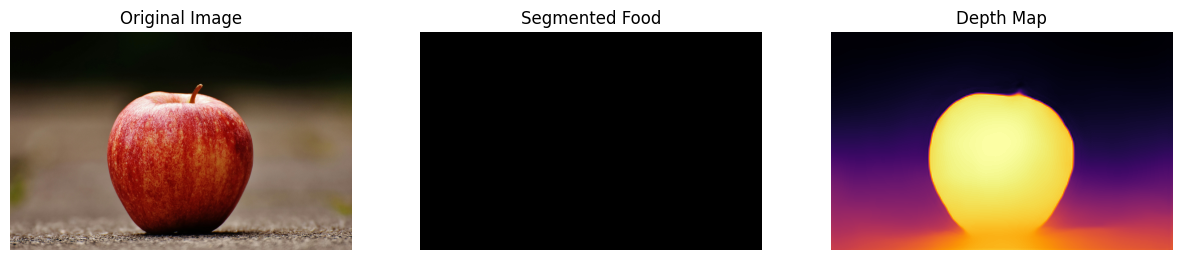

Estimated Volume: 0.00 cubic units


In [ ]:
main()